# Нейросетевые рекомендации

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/ncf_model.py

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request

from IPython.display import clear_output
from ncf_model import NCFData, NCF, create_dataloaders, train_NCF

Рассмотрим рекомендательную систему фильмов на основе нейронных сетей. Будем работать с данными, которые сожержат 1,000,209 анонимных рейтингов для примерно 3,900 фильмов от 6,040 пользователей MovieLens.

**План:**


1.   загрузим данные и посмотрим на них;
2.   обучим нейросетевую модель для рекомендаций Neural Collaborative Filtering (NCF);
3.   вычислим значения метрик качества рекомендаций;

**Source:** https://grouplens.org/datasets/movielens/1m/

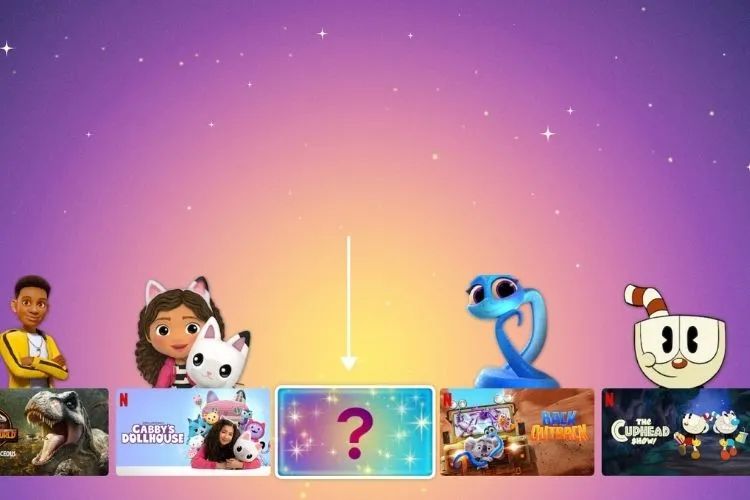

In [ ]:
MOVIES = "https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movie_lens_1m/movies.dat"
RATINGS = "https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movie_lens_1m/ratings.dat"
USERS = "https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movie_lens_1m/users.dat"

### Описание файла `movies.dat`

Информация в файле содержится в формате
`MovieID::Title::Genres`

- Title - название фильма (взято с IMDB) вместе с годом выпуска
- Жанры взяты из списка ниже и разделены символом `|`:

    * Action
    * Adventure
    * Animation
    * Children's
    * Comedy
    * Crime
    * Documentary
    * Drama
    * Fantasy
    * Film-Noir
    * Horror
    * Musical
    * Mystery
    * Romance
    * Sci-Fi
    * Thriller
    * War
    * Western

- Некоторые `MovieID` не соответствуют никакому фильму (из-за дублирований или других причин)
- Могут встречаться ошибки или неточности в данных, так как они изначально собирались вручную

In [ ]:
movies = pd.read_csv(
    MOVIES,
    sep="::",
    engine="python",
    header=None,
    encoding="latin-1"
)

movies.columns = ["MovieID", "Title", "Genres"]
movies.head(10)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### Описание файла `users.dat`

Информация в файле содержится в следующем формате:
`UserID::Gender::Age::Occupation::Zip-code`

Вся демографическая информация предоставлялась пользователями добровольно, поэтому может быть неточной.

- Gender (пол): "M" - мужской, "F" - женский
- Age (возраст) относится к одной из следующих групп:

    *  1:  "Under 18"
    * 18:  "18-24"
    * 25:  "25-34"
    * 35:  "35-44"
    * 45:  "45-49"
    * 50:  "50-55"
    * 56:  "56+"

- Occupation (вид занятости):

    *  0:  "other" or not specified
    *  1:  "academic/educator"
    *  2:  "artist"
    *  3:  "clerical/admin"
    *  4:  "college/grad student"
    *  5:  "customer service"
    *  6:  "doctor/health care"
    *  7:  "executive/managerial"
    *  8:  "farmer"
    *  9:  "homemaker"
    * 10:  "K-12 student"
    * 11:  "lawyer"
    * 12:  "programmer"
    * 13:  "retired"
    * 14:  "sales/marketing"
    * 15:  "scientist"
    * 16:  "self-employed"
    * 17:  "technician/engineer"
    * 18:  "tradesman/craftsman"
    * 19:  "unemployed"
    * 20:  "writer"

In [ ]:
users = pd.read_csv(
    USERS,
    sep="::",
    engine="python",
    header=None
    )

users.columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
users.head(10)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


### Описание файла `ratings.dat`

Рейтинги в файле представлены в формате

`UserID::MovieID::Rating::Timestamp`

- UserIDs: от 1 до 6040
- MovieIDs: от 1 до 3952
- Рейтинг (Rating) измеряется по 5-балльной шкале (только целые значения)
- Timestamp: временная отметка, когда был поставлен рейтинг
- У каждого пользователя есть хотя бы 20 рейтингов

In [ ]:
ratings = pd.read_csv(
    RATINGS,
    sep="::",
    engine="python",
    header=None
    )

ratings.columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings.head(10)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


# Предобработанные данные

Для построения нашей рекомендательной системы мы будем использовать уже подготовленные данные.

In [ ]:
TRAIN_RAITING = "https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movie_lens_1m/ml-1m.train.rating"
TEST_RAITING = "https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movie_lens_1m/ml-1m.test.rating"
TEST_NEGATIVE = "https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movie_lens_1m/ml-1m.test.negative"

Данные предварительно предобработаны:

**Файл train.rating:**
- Тренировочные данные
- В каждой строке содержится четверка значений `userID itemID rating timestamp`

In [ ]:
train_data = pd.read_csv(
    TRAIN_RAITING,
    sep="\t",
    header=None,
    names=["user", "item", "rating", "timestamp"],
    usecols=[0, 1, 2, 3],
    dtype={0: np.int32, 1: np.int32, 2: np.int32, 3: np.int32},
)
train_data.head()

,user,item,rating,timestamp
0,0,32,4,978824330
1,0,34,4,978824330
2,0,4,5,978824291
3,0,35,4,978824291
4,0,30,4,978824291


In [ ]:
user_num = train_data["user"].max() + 1 # число пользователей
item_num = train_data["item"].max() + 1 # число фильмов

user_num, item_num

(6040, 3706)

In [ ]:
train_data = train_data[["user", "item"]].values.tolist() # пары пользователь-фильм
train_data[:5]

[[0, 32], [0, 34], [0, 4], [0, 35], [0, 30]]

Матрица ретингов имеет вид:

* строки - пользователи

* столбцы - фильмы

* на пересечении - 0 (не смотрел фильм) или 1 (смотрел)

In [ ]:
import scipy.sparse as sp

train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
for x in train_data:
    train_mat[x[0], x[1]] = 1.0

**Файл test.rating:**
- Тестовые данные (только случаи, когда взаимодействие было)
- В каждой строке содержится четверка значений `userID itemID rating timestamp`

In [ ]:
test_data = pd.read_csv(
    TEST_RAITING,
    sep="\t",
    header=None,
    names=["user", "item", "rating", "timestamp"],
    usecols=[0, 1, 2, 3],
    dtype={0: np.int32, 1: np.int32, 2: np.int32, 3: np.int32},
)
test_data.head()

,user,item,rating,timestamp
0,0,25,5,978824351
1,1,133,3,978300174
2,2,207,4,978298504
3,3,208,4,978294282
4,4,222,2,978246585


**Файл test.negative**
- Тестовые данные (случаи отрицательного взаимодействия, то есть случаи отсутствия взаимодействия пользователя и фильма)
- Каждая строчка соответствует строке из файла test.rating и содержит 1 положительное и 99 отрицательных взаимодействий
- Каждая строчка имеет формат: `(userID,itemID) negativeItemID1 negativeItemID2`

Это подготовленный набор данных, который мы будем использовать для тестирования нашей рекомендательной системы. Для каждого пользователя он содержит 1 фильм, который он смотрел, и 99 фильмов, которые он НЕ смотрел. Мы будем использовать их для подсчета метрик качества.

In [ ]:
urllib.request.urlretrieve(TEST_NEGATIVE, "ml-1m.test.negative")

('ml-1m.test.negative', <http.client.HTTPMessage at 0x7d8213776b90>)

In [ ]:
test_data = []
with open("ml-1m.test.negative", "r") as fd:
    line = fd.readline()
    while line != None and line != "":
        arr = line.split("\t")
        u = eval(arr[0])[0]
        test_data.append([u, eval(arr[0])[1]])
        for i in arr[1:]:
            test_data.append([u, int(i)])
        line = fd.readline()

In [ ]:
test_data[:5]

[[0, 25], [0, 1064], [0, 174], [0, 2791], [0, 3373]]

# Обучим и применим NCF-модель


В классе NCFData происходит обработка данных и представление их в виде, в котором дальше будет удобно обучение.

In [ ]:
train_dataset = NCFData(train_data, item_num, train_mat, num_ng=1, is_training=True)
test_dataset = NCFData(test_data, item_num, train_mat, num_ng=0, is_training=False)

In [ ]:
# попросим класс добавить num_ng негативных примеров (фильмы, которые не смотрел пользователь)
train_dataset.ng_sample()  # для train_dataset num_ng = 1

In [ ]:
# пример использования
print("User, Item, Label")

for idx, (user, item, label) in enumerate(train_dataset):
    print(user, item, label)
    if idx > 5:
        break

User, Item, Label
0 32 1
0 34 1
0 4 1
0 35 1
0 30 1
0 29 1
0 33 1


Создадим `train_loader` и `test_loader` - специальные объекты библиотеки PyTorch, которые позволяют удобно итерироваться по батчам и обучать и применять модель.

In [ ]:
train_loader, test_loader = create_dataloaders(train_dataset, test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Neural Collaborative Filtering (NCF)

Все готово для обучения нашей модели!

**NCF** - это нейронная модель матричной факторизации, которая объединяет **Generalized Matrix Factorization (GMF)** и **Multi-Layer Perceptron (MLP)**, объединяя в себе сильные стороны линейности MF и нелинейности MLP для моделирования скрытых структур user-item.

Схема архитектуры **NCF**:

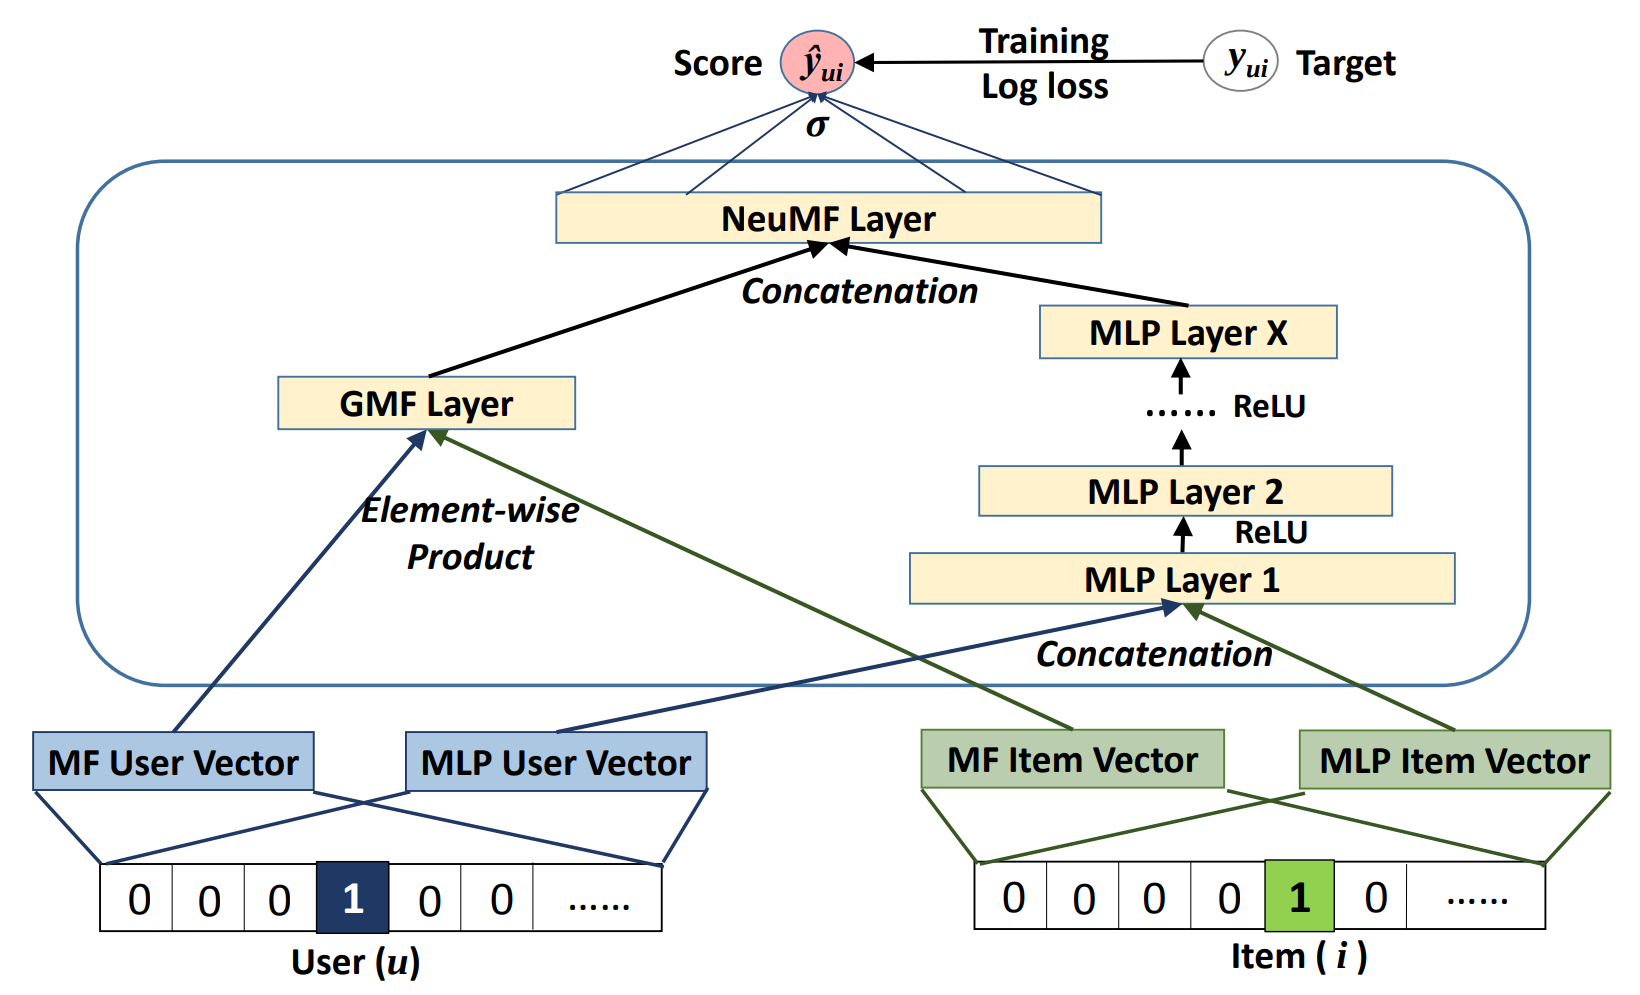

* объявляем модель (NCF)

* объявляем функцию потерь `loss_function`

* объявляем оптимизатор `optimizer`

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NCF(
    user_num, item_num, factor_num=32, num_layers=3, dropout=0.0, model="NeuMF-end"
)
model.to(DEVICE)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Обучаем модель

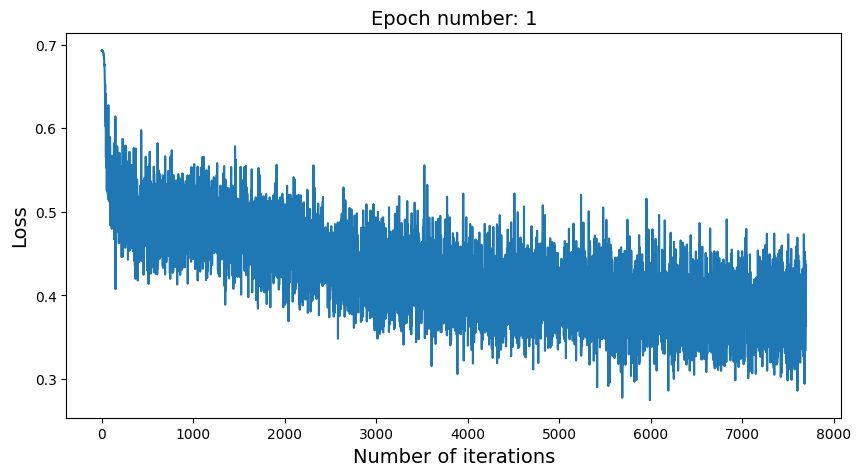

In [ ]:
train_NCF(model, train_loader, loss_function, optimizer)

# Метрики качества

**Метрики качества предсказания событий:**

$$Hitrate@k = |R_u (k) \cap L_u|$$

$$Precision@k = \frac{|R_u (k) \cap L_u|}{|R_u (k)|}$$

$$Recall@k = \frac{|R_u (k) \cap L_u|}{|L_u|}$$

где $R_u$ (k) - список k лучших рекомендаций алгоритма; $L_u$ - список фильмов, которые пользователь реально посмотрел.


**Метрики качества ранжирования:**

$$ DCG@k =  \sum_{p=1}^{k} g(r_{ui_{p}}) d(p) $$

где $p$ - позиция фильма в списке рекомендаций; $g(r) = 2^r - 1$; $d(p) = \frac{1}{\log(p+1)}$.

$$ nDCG@k =  \frac{DCG@k}{max DCG@k}$$

Функция для подсчета `Hitrate@k`.

In [ ]:
def hit(gt_item, pred_items):
    """
    gt_item : ID фильма, который пользователь реально посмотрел.
    pred_items: спискок К рекомендаций фильмов.

    Пример:
    gt_item = 25
    pred_items = [128, 25, 174, 273, 175, 1135, 1182, 617, 58, 1902]
    """
    if gt_item in pred_items:
        return 1
    return 0

Функция для подсчета `nDCG@k`. Используйте $g(r) = 1$.

In [ ]:
def ndcg(gt_item, pred_items):
    """
    gt_item : ID фильма, который пользователь реально посмотрел.
    pred_items: спискок К рекомендаций фильмов.

    Пример:
    gt_item = 25
    pred_items = [128, 25, 174, 273, 175, 1135, 1182, 617, 58, 1902]
    """
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index + 2))
    return 0

Функция, вычисляющая средние значения метрик качества на тестовых данных.

In [ ]:
def metrics(model, test_loader, top_k):
    HR, NDCG = [], []

    for user, item, label in test_loader:

        user = user.to(DEVICE)
        item = item.to(DEVICE)

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

    return np.mean(HR), np.mean(NDCG)

Посчитаем метрики качества на тесте.

In [ ]:
model.eval()
HR, NDCG = metrics(model, test_loader, top_k=10)
HR, NDCG

(0.5841059602649007, 0.32606065067074735)